# Correlation between SSD symptoms and causality judgement



In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind as ttest
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import json

import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import bambi as bmb
print(f"Running on bmb v{bmb.__version__}")
import arviz as az
az.style.use("arviz-darkgrid") # make e.g. forestplot use a grid

# custom scripts
import dataLoader
from buttler import *

with open("./settings.json") as f:
    settings = json.load(f)

Running on PyMC v5.6.1
Running on bmb v0.12.0


## 0. Load and Pre-process Data

In [2]:
# %%capture --no-display --no-stdout
# data loading and pre-processing
df, SESSION_IDS = dataLoader.loadCausalityData()
df = dataLoader.shiftColumns(df, ["causality_judgement", "time", "angle"], SESSION_IDS)

# add columns that count sequences of 'causa'/'non-causal' responses
df = df.groupby(SESSION_IDS, group_keys=False).apply(countResponses)
# display(df.head(3))

# select and rename needed columns
data = df [["subject_id", "baseline_stimulation", "stimulation", "group", "causality_judgement1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "causality_judgement", "RT", "RT_corrected_for_delay"]]
data.columns = ["subj", "base_stim", "stim", "group", "c1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "c", "rt", "rt_c"]

DATA_SESSION_IDS = ['subj', 'base_stim', 'stim', 'group']

# name categorical values
data.loc[:, "group"] = data.loc[:, "group"].replace({0: "HC", 1: "SZ"})
# data["group"] = data["group"].replace({0: "HC", 1: "SZ"}) # Has same effect and throws same error as above...
data["c"] = data["c"].replace({0: "non_causal", 1: "causal"})
data["c1"] = data["c1"].replace({0: "non_causal", 1: "causal"})
data.head(3)

Causality data shape: (42966, 10)
Shifted Data shape: (42526, 13)


C:\Users\key\AppData\Local\Temp\ipykernel_21692\380323668.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["c"] = data["c"].replace({0: "non_causal", 1: "causal"})
C:\Users\key\AppData\Local\Temp\ipykernel_21692\380323668.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["c1"] = data["c1"].replace({0: "non_causal", 1: "causal"})


subj  base_stim  stim group          c1  time  time1  angle  angle1  \
id                                                                        
1    2.0        1.0   1.0    HC      causal   0.0    4.0   30.0    22.5   
2    2.0        1.0   1.0    HC      causal  16.0    0.0   22.5    30.0   
3    2.0        1.0   1.0    HC  non_causal   0.0   16.0    0.0    22.5   

    c_seq  nc_seq           c      rt     rt_c  
id                                              
1       1       0      causal  1480.6  1480.60  
2       2       0  non_causal  1615.0  1348.44  
3       0       1      causal  1395.2  1395.20

Prepare data for modelling

In [3]:
# standardize data
for col in ["angle", "angle1", "time", "time1"]:
    data[col + "_std"] = standardize(data[col])

# normalize data
data = data.groupby(["subj"], group_keys=False).apply(normalize, ["rt", "rt_c", "angle", "time", "angle1", "time1"])
data.columns

# nest data
nested_model_data, new_cols_c1 = nestPredictors(data, "c1", "group", drop_inner=False)
nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_std", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_std", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_norm", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_norm", "group", drop_inner=False)

def split_tDCS(group:pd.DataFrame) -> pd.DataFrame:
    stim = group["stim"].iloc[0]
    group["tDCS_" + str(int(stim))] = group["base_stim"] == 2
    return group

nested_model_data = nested_model_data.groupby(["stim"], group_keys=False).apply(split_tDCS)

def apply_tDCS_contrasts(data:pd.DataFrame) -> pd.DataFrame:
    data2 = data.copy()
    constrasts = {
        True: 1,
        False: -1,
        np.NaN: 0
    }
    columns = ["tDCS_" + str(i+1) for i in range(7)]

    data2[columns] = data2[columns].replace(constrasts)
    return data2

nested_model_data = applyCustomConstrasts(nested_model_data, columns=["c1", "group", "c1_HC", "c1_SZ"], kind="Sum")
nested_model_data = apply_tDCS_contrasts(nested_model_data)

# custom nesting for last trial properties
nested_model_data["time1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["time1_norm"]
nested_model_data["time1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["time1_norm"]
nested_model_data["angle1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["angle1_norm"]
nested_model_data["angle1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["angle1_norm"]

display(nested_model_data.head(2))

# rename time to delay
new_cols = []
for n in nested_model_data.columns:
    n = n.replace("time", "delay")
    new_cols.append(n)

nested_model_data.columns = new_cols
nested_model_data.columns

subj  base_stim  stim  group  c1  time  time1  angle  angle1  c_seq  ...  \
id                                                                       ...   
1    2.0        1.0   1.0     -1   1   0.0    4.0   30.0    22.5      1  ...   
2    2.0        1.0   1.0     -1   1  16.0    0.0   22.5    30.0      2  ...   

    tDCS_2 tDCS_3  tDCS_4  tDCS_5  tDCS_6  tDCS_7  time1_norm_HC  \
id                                                                 
1      0.0    0.0     0.0     0.0     0.0     0.0      -0.547538   
2      0.0    0.0     0.0     0.0     0.0     0.0      -1.312343   

    time1_norm_SZ  angle1_norm_HC  angle1_norm_SZ  
id                                                 
1            -0.0       -0.159477            -0.0  
2            -0.0        0.224911             0.0  

[2 rows x 49 columns]

Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'delay', 'delay1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'delay_std', 'delay1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'delay_norm', 'angle1_norm', 'delay1_norm', 'c1_HC',
       'c1_SZ', 'delay_HC', 'delay_SZ', 'angle_HC', 'angle_SZ', 'delay_std_HC',
       'delay_std_SZ', 'angle_std_HC', 'angle_std_SZ', 'delay_norm_HC',
       'delay_norm_SZ', 'angle_norm_HC', 'angle_norm_SZ', 'tDCS_1', 'tDCS_2',
       'tDCS_3', 'tDCS_4', 'tDCS_5', 'tDCS_6', 'tDCS_7', 'delay1_norm_HC',
       'delay1_norm_SZ', 'angle1_norm_HC', 'angle1_norm_SZ'],
      dtype='object')

In [4]:
# load demographic and psychopathological data

subj_data = dataLoader.loadParticipantData()

# filter out dropped partiipants
subj_data = subj_data.loc[subj_data.index != 16, :]
subj_data = subj_data.loc[subj_data.index != 104, :]

# add group columns
subj_data["group"] = subj_data.index >= 100
subj_data["group"].replace({True: "SSD", False:"HC"}, inplace=True)

# translate relevant questions to English
subj_data = subj_data.rename(columns={
    "Ich habe die Aufgabenstellung bei den Ball-Videos verstanden.": "I understood the ball-video task.", 
    "Nach den Ball-Videos hatte ich genug Zeit, um mich zu entscheiden und zu drücken.": "After the ball videos I had enough time for my decision and button press.", 
    "Ich habe bei den Ball-Videos häufig aus Versehen falsch gedrückt.": "In the ball videos, I often pushed the wrong button accidentally.",
    "Ich konnte mich am Ende des Versuchs (Ball-Videos) noch ausreichend konzentrieren.": "I could still concentrate sufficiently by the end of the experiment (ball videos).",
    "Bei den meisten Ball-Videos war ich sicher, was ich antworten sollte.": "With most ball videos I was certain about my answer.",
    "Ich konnte mich am Ende des Tastendruck-Versuchs noch ausreichend konzentrieren.": "I could still concentrate sufficiently by the end of the experiment (button press).",
})

## 1. Test on group differences wrt demographic and test data

We need to clarify how statistically different the two groups (HCs and SSDs) are with respect to their demographic data and their performance in the conducted cognitive tests.

In [5]:
def cohens_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt( (np.var(x) * len(x) + np.var(y) * len(y) ) / (len(x) + len(y)))
    # return (x.mean() - y.mean()) / np.sqrt((x.var() * len(x) + y.var() * len(y)) / (len(x)+len(y))) # gives slightly different result!

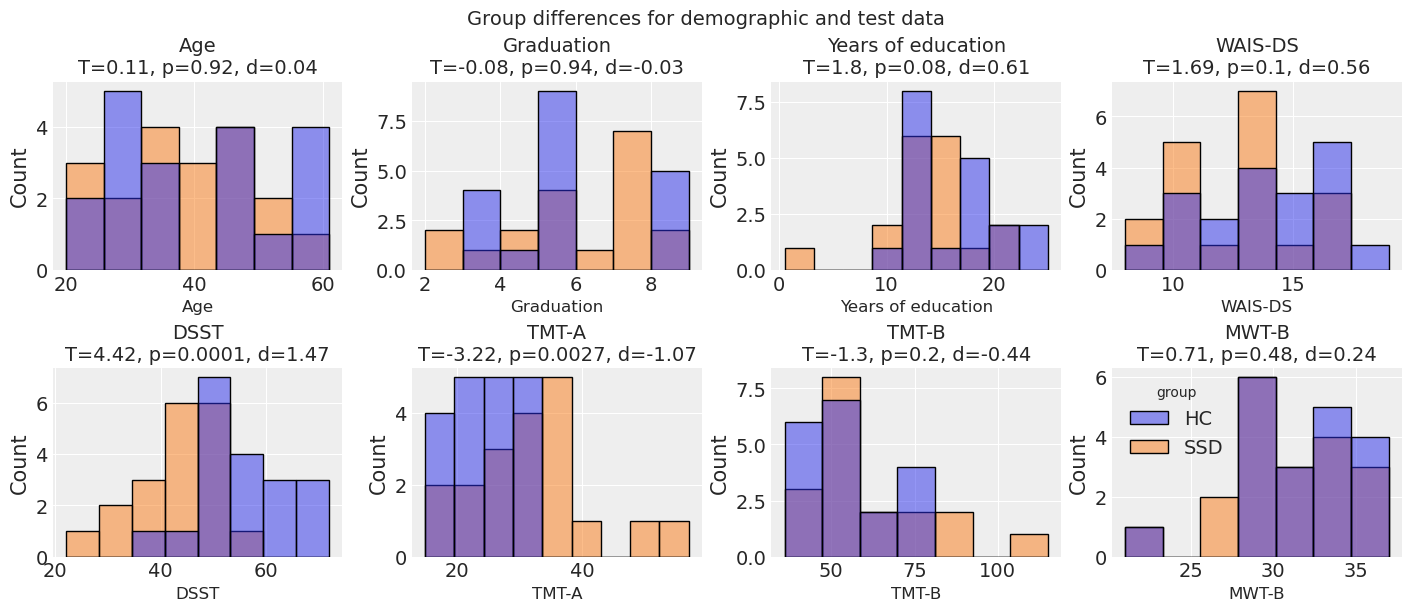

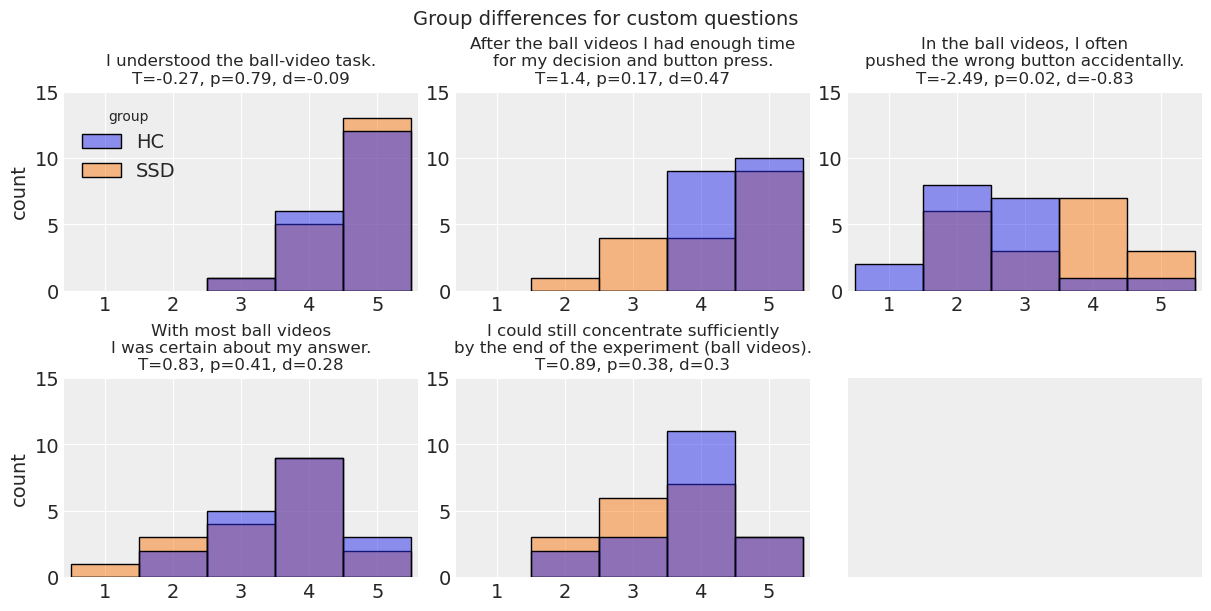

In [6]:
hcs = subj_data.loc[:100, :]
ssds = subj_data.loc[100:, :]

# Test results
vars = ["Age", "Graduation", "Years of education", 
        "WAIS-DS", "DSST", 
        "TMT-A", "TMT-B", "MWT-B",
        ]

fig, axs = plt.subplots(2,4, figsize=(14,6))
axs = axs.flatten()

for i, var in enumerate(vars):
    a = hcs[var]
    b = ssds[var].dropna()
    res = ttest(a, b)
    show_legend = i == len(axs)-1
    sns.histplot(subj_data, x=var, hue="group", ax=axs[i], legend=show_legend, stat="count")
    p_rounding = 4 if i==4 or i==5 else 2
    axs[i].set_title(f"{var}\nT={round(res.statistic, 2)}, p={round(res.pvalue, p_rounding)}, d={round(cohens_d(a,b), 2)}", fontsize=14) # df={round(res.df, 2)},
    axs[i].set_xlabel(var, fontsize=12)
plt.suptitle("Group differences for demographic and test data", fontsize=14)
plt.tight_layout()
# plt.savefig("figures/group_comparison_demographics_and_tests.pdf")
plt.show()

# Relevant Answers to custom questions
vars = ["I understood the ball-video task.", 
        "After the ball videos I had enough time for my decision and button press.", 
        "In the ball videos, I often pushed the wrong button accidentally.",
        "With most ball videos I was certain about my answer.",
        "I could still concentrate sufficiently by the end of the experiment (ball videos).",
        # "I could still concentrate sufficiently by the end of the experiment (button press).",
        ]

labels = ["I understood the ball-video task.", 
        "After the ball videos I had enough time\nfor my decision and button press.", 
        "In the ball videos, I often\npushed the wrong button accidentally.",
        "With most ball videos\nI was certain about my answer.",
        "I could still concentrate sufficiently\nby the end of the experiment (ball videos).",
        # "I could still concentrate sufficiently\nby the end of the experiment (button press).",
        ]

fig, axs = plt.subplots(2,3, figsize=(12,6))
axs = axs.flatten()

for i, var in enumerate(vars):
    a = hcs[var]
    b = ssds[var].dropna()
    res = ttest(a, b)
    show_legend = i == 0
    sns.histplot(subj_data, x=var, hue="group", ax=axs[i], legend=show_legend, stat="count", discrete=True)
    axs[i].set_title(f"{labels[i]}\nT={round(res.statistic, 2)}, p={round(res.pvalue, 2)}, d={round(cohens_d(a,b), 2)}", fontsize=12)
    axs[i].set_xlabel("", fontsize=14)
    axs[i].set_ylabel("", fontsize=14)
    axs[i].set_ylim(0, 15)
    axs[i].set_xlim(0.4,5.6)
    axs[i].set_xticks([1,2,3,4,5])

axs[0].set_ylabel("count")
axs[3].set_ylabel("count")
axs[5].set_xticks([])
axs[5].set_yticks([])
plt.suptitle("Group differences for custom questions", fontsize=14)
plt.tight_layout()
# plt.savefig("figures/group_comparison_questions.pdf")
plt.show()

## 2. Correlation with causality judgements

Let's exercise through a simple correlation between some interesting participant characteristics and their general tendency to respond causal or non-causal in the Michotte-Launching task.

In [7]:
subj_perf = data.replace({"non_causal": 0, "causal": 1})[["subj", "c", "rt", "rt_c"]].groupby("subj").mean(numeric_only=True)
subj_perf = subj_perf.loc[subj_perf.index != 16, :]
subj_perf = subj_perf.loc[subj_perf.index != 104, :]

subj_data = pd.merge(subj_data, subj_perf, left_index=True, right_index=True)
subj_data.index.name = "subj"
subj_data.reset_index(inplace=True)

In [8]:
# translate relevant SAPS and SANS fields
subj_data.rename(columns={
    "Gesamtwert_Subskalenwerte_SANS": "SANS",
    "Subskalenwert_5_SANS": "SANS 5", 
    "Subskalenwert_1_SANS": "SANS 1",
    "Subskalenwert_2_SANS": "SANS 2",
    "Subskalenwert_3_SANS": "SANS 3",
    "Subskalenwert_4_SANS": "SANS 4",
    "Gesamtskalenwert_SAPS": "SAPS", 
    "Subskalenwert_2_SAPS": "SAPS 2",
    "Subskalenwert_3_SAPS": "SAPS 3",
    "Subskalenwert_4_SAPS": "SAPS 4"
}, inplace=True)

ssds = subj_data[subj_data["subj"] >= 100]
sans_vars = [
    "SANS",
    "SANS 5", # Unaufmerksamkeit
    # "SANS 1",
    # "SANS 2",
    # "SANS 3",
    # "SANS 4",
]
saps_vars = [
    "SAPS", 
    "SAPS 2", # Wahn/ Delusions
    # "SAPS 3",
    # "SAPS 4"
]

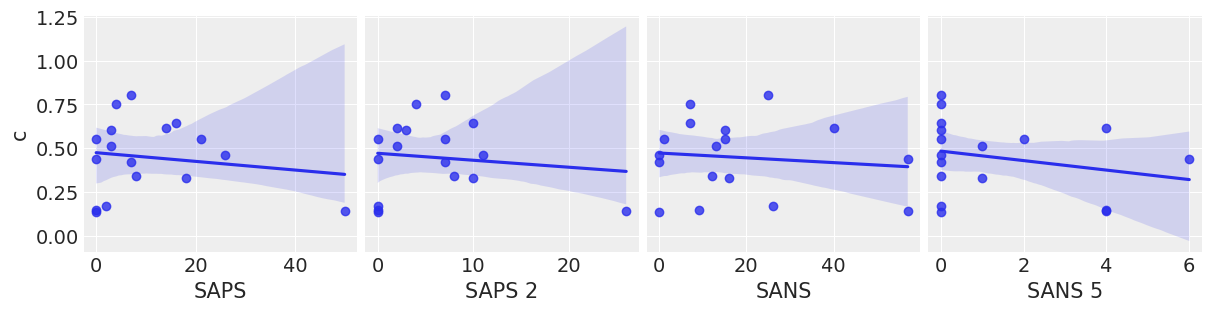

In [9]:
sns.pairplot(ssds, x_vars=[*saps_vars, *sans_vars], y_vars=["c"], kind="reg", height=3)

In [10]:
dep_vars = ["c", "rt"]
indep_vars = [*saps_vars, *sans_vars]
confidence_level=0.94

for dep_var in dep_vars:
    print(f"Dependant variable: {dep_var}")
    for indep_var in indep_vars:
        print(f"Independent variable: {indep_var}")
        df = ssds[[dep_var, indep_var]].dropna()
        res = stats.pearsonr(df[indep_var], df[dep_var])
        ci = res.confidence_interval(confidence_level=confidence_level) # computed using Fisher transformation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
        print(f"\tstatistic: {round(res.statistic, 2)}, p: {round(res.pvalue, 2)}")
        print(f"\tCI: low: {round(ci.low, 2)}, high: {round(ci.high, 2)}")
    print()

Dependant variable: c
Independent variable: SAPS
	statistic: -0.15, p: 0.56
	CI: low: -0.58, high: 0.34
Independent variable: SAPS 2
	statistic: -0.12, p: 0.64
	CI: low: -0.56, high: 0.36
Independent variable: SANS
	statistic: -0.12, p: 0.65
	CI: low: -0.55, high: 0.37
Independent variable: SANS 5
	statistic: -0.25, p: 0.33
	CI: low: -0.64, high: 0.24

Dependant variable: rt
Independent variable: SAPS
	statistic: -0.25, p: 0.34
	CI: low: -0.64, high: 0.24
Independent variable: SAPS 2
	statistic: -0.27, p: 0.3
	CI: low: -0.65, high: 0.22
Independent variable: SANS
	statistic: -0.1, p: 0.7
	CI: low: -0.54, high: 0.38
Independent variable: SANS 5
	statistic: 0.0, p: 1.0
	CI: low: -0.46, high: 0.47



## 3. Correlation with model parameters
Now, let us go a step further and correlate participant characteristics with the respective subject-level parameters we can extract from one of our models that applies random-effects.

### Participant specific intercept (full model)

In [11]:
# load "full" model from file
TRACE_PATH = os.path.join(settings["trace_path"], "causality", "overview")
trace_file = os.path.join(TRACE_PATH, "trial_properties_c1_interactions_full_pre.nc")
trae_pre = az.from_netcdf(trace_file)

In [12]:
model_pre_sum = az.summary(trae_pre)
model_pre_sum.index.name = "parameter"
model_pre_sum.reset_index(inplace=True)

# filter for subject specific parameters
subj_params = model_pre_sum.loc[model_pre_sum["parameter"].str.contains("1\|subj\["), :][["parameter", "mean"]]

# rename and restructure
subj_params["subj"] = [float(param.split("[")[1].split(".")[0]) for param in subj_params.parameter]
subj_params.drop(columns="parameter", inplace=True)
subj_params.rename(columns={"mean": "subject intercept"}, inplace=True)

# add to subj_data
subj_data = pd.merge(subj_data, subj_params, left_on="subj", right_on="subj")

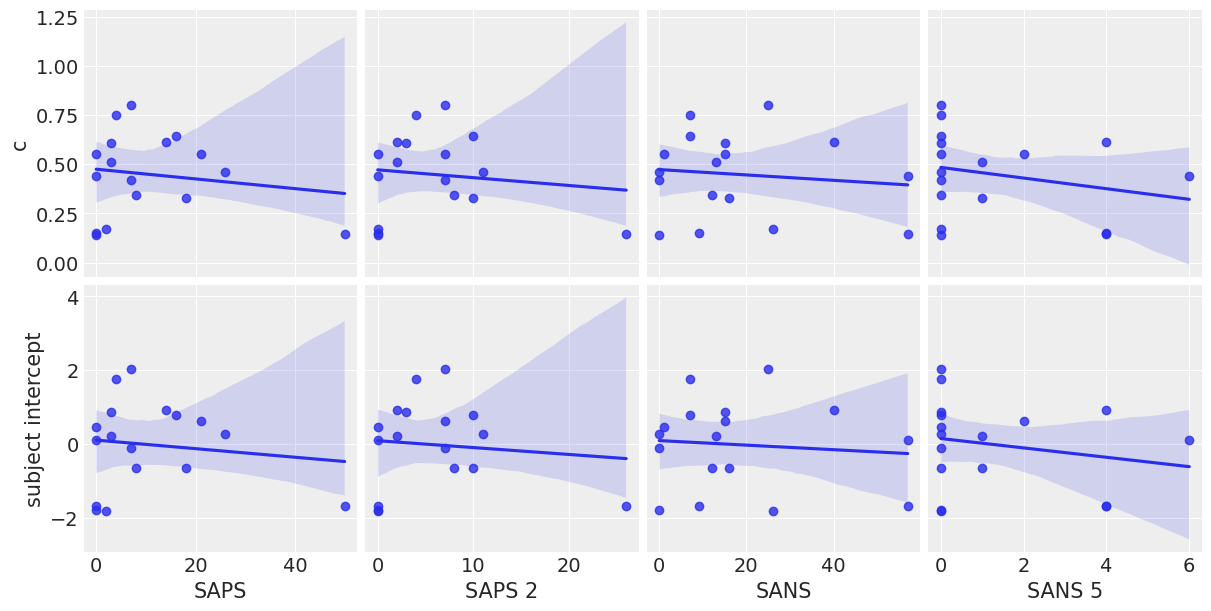

In [13]:
ssds = subj_data[subj_data["subj"] >= 100]

sns.pairplot(ssds, x_vars=[*saps_vars, *sans_vars], y_vars=["c", "subject intercept"], kind="reg", height=3)

In [14]:
dep_vars = ["subject intercept"]
indep_vars = [*saps_vars, *sans_vars]
confidence_level=0.94

for dep_var in dep_vars:
    print(f"Dependant variable: {dep_var}")
    for indep_var in indep_vars:
        print(f"Independent variable: {indep_var}")
        df = ssds[[dep_var, indep_var]].dropna()
        res = stats.pearsonr(df[indep_var], df[dep_var])
        ci = res.confidence_interval(confidence_level=confidence_level) # computed using Fisher transformation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
        print(f"\tstatistic: {round(res.statistic, 2)}, p: {round(res.pvalue, 2)}")
        print(f"\tCI: low: {round(ci.low, 2)}, high: {round(ci.high, 2)}")
    print()

Dependant variable: subject intercept
Independent variable: SAPS
	statistic: -0.13, p: 0.63
	CI: low: -0.56, high: 0.36
Independent variable: SAPS 2
	statistic: -0.1, p: 0.7
	CI: low: -0.54, high: 0.38
Independent variable: SANS
	statistic: -0.09, p: 0.72
	CI: low: -0.53, high: 0.39
Independent variable: SANS 5
	statistic: -0.21, p: 0.43
	CI: low: -0.61, high: 0.28



### Participant specific angle weight

In [15]:
data_pre = nested_model_data[nested_model_data["base_stim"] == 1]

TRACE_PATH = os.path.join(settings["trace_path"], "causality", "random_slopes")
trace_file = os.path.join(TRACE_PATH, "g_drs_ars_c1rs_ri.nc")

model_random_slopes = bmb.Model("c ~ group + (delay_norm|subj) + (angle_norm|subj) + (c1|subj) + (1|subj)", data_pre, family="bernoulli")
trace_random_slopes = loadOrSample(model_random_slopes, trace_file, force_sample=False)

Loading trace from file.


In [16]:
trace_random_slopes_sum = az.summary(trace_random_slopes)
trace_random_slopes_sum.index.name = "parameter"
trace_random_slopes_sum.reset_index(inplace=True)

# filter for subject specific parameters
subj_params = trace_random_slopes_sum.loc[trace_random_slopes_sum["parameter"].str.contains("\|subj\["), :][["parameter", "mean"]]

# rename and restructure
subj_params["subj"] = [float(param.split("[")[1].split(".")[0]) for param in subj_params["parameter"]]
subj_params["parameter"] = [param.split("|")[0] for param in subj_params["parameter"]]
subj_params.rename(columns={"mean": "value"}, inplace=True)

# rename parameters
subj_params["parameter"].replace({"1":"intercept", "delay_norm": "delay", "angle_norm": "angle", "c1": "last_choice"}, inplace=True)
# pivot to wide format
subj_params = subj_params.pivot_table(values="value", index="subj", columns="parameter")

# add to subj_data
subj_data = pd.merge(subj_data, subj_params, left_on="subj", right_on="subj")

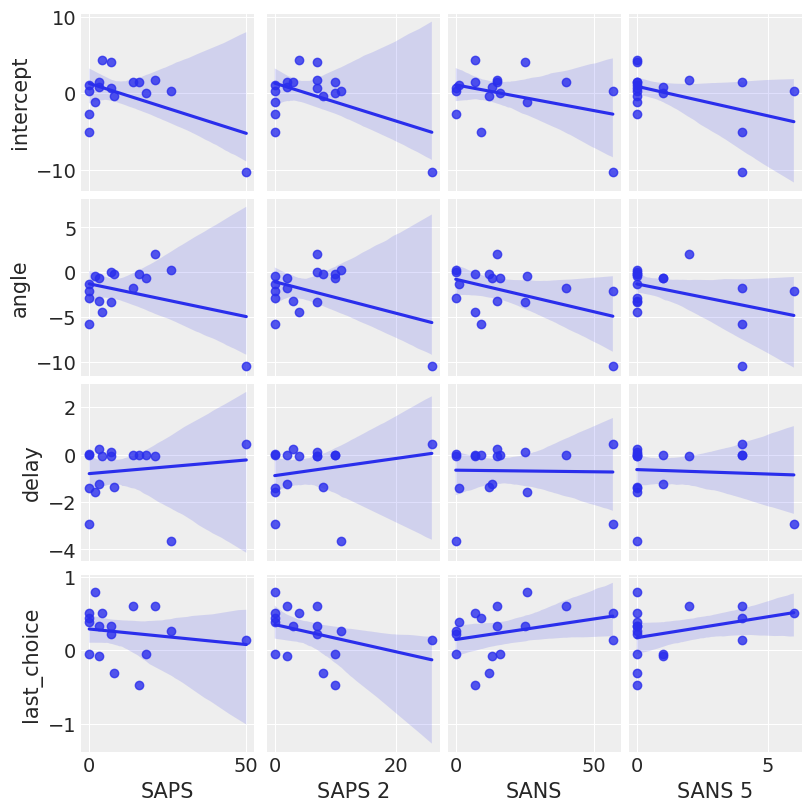

In [17]:
ssds = subj_data[subj_data["subj"] >= 100]

sns.pairplot(ssds, x_vars=[*saps_vars, *sans_vars], y_vars=["intercept", "angle","delay", "last_choice"], kind="reg", height=2)

In [18]:
dep_vars = ["intercept", "angle","delay", "last_choice"]
indep_vars = [*saps_vars, *sans_vars]
confidence_level=0.94

for dep_var in dep_vars:
    print(f"Dependant variable: {dep_var}")
    for indep_var in indep_vars:
        print(f"Independent variable: {indep_var}")
        df = ssds[[dep_var, indep_var]].dropna()
        res = stats.pearsonr(df[indep_var], df[dep_var])
        ci = res.confidence_interval(confidence_level=confidence_level) # computed using Fisher transformation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
        print(f"\tstatistic: {round(res.statistic, 2)}, p: {round(res.pvalue, 2)}")
        print(f"\tCI: low: {round(ci.low, 2)}, high: {round(ci.high, 2)}")
    print()

Dependant variable: intercept
Independent variable: SAPS
	statistic: -0.5, p: 0.04
	CI: low: -0.78, high: -0.04
Independent variable: SAPS 2
	statistic: -0.47, p: 0.06
	CI: low: -0.77, high: -0.01
Independent variable: SANS
	statistic: -0.36, p: 0.16
	CI: low: -0.7, high: 0.13
Independent variable: SANS 5
	statistic: -0.44, p: 0.08
	CI: low: -0.75, high: 0.03

Dependant variable: angle
Independent variable: SAPS
	statistic: -0.33, p: 0.2
	CI: low: -0.69, high: 0.16
Independent variable: SAPS 2
	statistic: -0.4, p: 0.12
	CI: low: -0.73, high: 0.08
Independent variable: SANS
	statistic: -0.45, p: 0.07
	CI: low: -0.76, high: 0.01
Independent variable: SANS 5
	statistic: -0.4, p: 0.12
	CI: low: -0.73, high: 0.08

Dependant variable: delay
Independent variable: SAPS
	statistic: 0.13, p: 0.63
	CI: low: -0.36, high: 0.56
Independent variable: SAPS 2
	statistic: 0.2, p: 0.44
	CI: low: -0.29, high: 0.61
Independent variable: SANS
	statistic: -0.02, p: 0.94
	CI: low: -0.48, high: 0.45
Independen

## 4. Attention of SSDs
During revision the point was raised that especially SSDs might simply loose focus after a while and report the same answer irrespective of a trial's cues towards the end of a session.

In [19]:
# mark the 4 batches in data
def mark_batch(group, name_stem:str):
    split_idx = group.iloc[int(group.shape[0] / 2),:].name
    group.loc[:split_idx, "batch"] = name_stem + "1"
    group.loc[split_idx:, "batch"] = name_stem + "2"
    return group

data_pre = data[data["base_stim"] == 1]
data_pre = data_pre.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(mark_batch, "pre")

data_post = data[data["base_stim"] == 2]
data_post = data_post.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(mark_batch, "post")

data = pd.concat([data_pre, data_post])

# add column to track same answer
data["same_answer"] = (data["c"] == data["c1"]).astype(int)

Population level development of causal or same answer given

Post 1 c: TtestResult(statistic=-4.396909029195867, pvalue=1.108811412526671e-05, df=10525.0)
Pre 2 same anser: TtestResult(statistic=-4.72226057823567, pvalue=2.3619121634165576e-06, df=10736.0)
Post 1 same anser: TtestResult(statistic=-2.1673682206943696, pvalue=0.0302291379033496, df=10525.0)
Post 2 same anser: TtestResult(statistic=-5.034750628247064, pvalue=4.862446523828923e-07, df=10726.0)


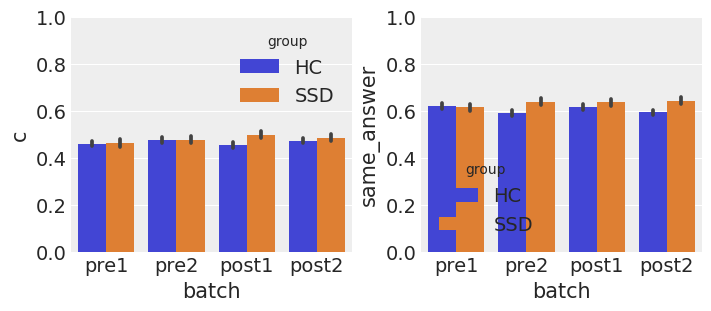

In [20]:
dfp = data.replace({"causal": 1, "non_causal": 0, "SZ": "SSD"})
fig, axs = plt.subplots(1,2, figsize=(7,3))
sns.barplot(dfp, x="batch", y="c", hue="group", ax = axs[0], errorbar="ci")
sns.barplot(dfp, x="batch", y="same_answer", hue="group", ax=axs[1])

for ax in axs:
    ax.set_ylim(0,1)

a = dfp[(dfp["batch"] == "post1") & (dfp["group"] == "HC")]["c"]
b = dfp[(dfp["batch"] == "post1") & (dfp["group"] == "SSD")]["c"]
print(f"Post 1 c: {ttest(a,b)}")
a = dfp[(dfp["batch"] == "pre2") & (dfp["group"] == "HC")]["same_answer"]
b = dfp[(dfp["batch"] == "pre2") & (dfp["group"] == "SSD")]["same_answer"]
print(f"Pre 2 same anser: {ttest(a,b)}")
a = dfp[(dfp["batch"] == "post1") & (dfp["group"] == "HC")]["same_answer"]
b = dfp[(dfp["batch"] == "post1") & (dfp["group"] == "SSD")]["same_answer"]
print(f"Post 1 same anser: {ttest(a,b)}")
a = dfp[(dfp["batch"] == "post2") & (dfp["group"] == "HC")]["same_answer"]
b = dfp[(dfp["batch"] == "post2") & (dfp["group"] == "SSD")]["same_answer"]
print(f"Post 2 same anser: {ttest(a,b)}")

Per participant analysis of answer behaviour development

Text(0.5, 1.0, 'Repeated answers per subj (SSD)')

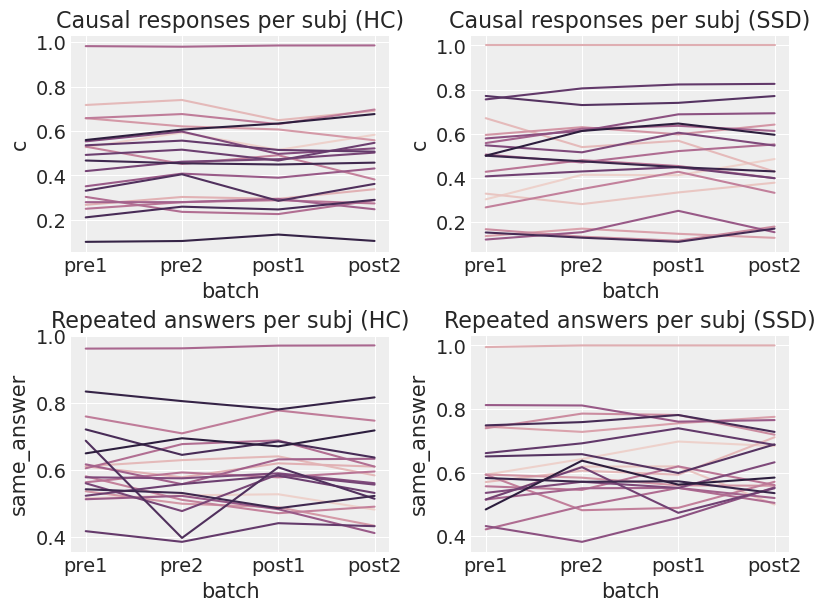

In [21]:
dfp = data.replace({"causal": 1, "non_causal": 0, "SZ": "SSD"})
dfp_hc = dfp[dfp["group"] == "HC"]
dfp_ssd = dfp[dfp["group"] == "SSD"]

fig, axs = plt.subplots(2,2, figsize=(8,6))
axs = axs.flatten()
sns.lineplot(dfp_hc, x="batch", y="c", hue="subj", errorbar=None, ax=axs[0], legend=False)
sns.lineplot(dfp_ssd, x="batch", y="c", hue="subj", errorbar=None, ax=axs[1], legend=False)
sns.lineplot(dfp_hc, x="batch", y="same_answer", hue="subj", errorbar=None, ax=axs[2], legend=False)
sns.lineplot(dfp_ssd, x="batch", y="same_answer", hue="subj", errorbar=None, ax=axs[3], legend=False)

axs[0].set_title("Causal responses per subj (HC)")
axs[1].set_title("Causal responses per subj (SSD)")
axs[2].set_title("Repeated answers per subj (HC)")
axs[3].set_title("Repeated answers per subj (SSD)")

In [22]:
# compress the development per participant in a number
def calculcate_change_in_same_answer(part):
    pre1_mean = part[part["batch"] == "pre1"]["same_answer"].mean()
    pre2_mean = part[part["batch"] == "pre2"]["same_answer"].mean()
    post1_mean = part[part["batch"] == "post1"]["same_answer"].mean()
    post2_mean = part[part["batch"] == "post2"]["same_answer"].mean()

    return post2_mean - pre1_mean

same_answer_average_change = data.groupby(["subj"]).apply(calculcate_change_in_same_answer)
same_answer_average_change.name = "saac"

# add to subject data dataframe
saac = pd.DataFrame(same_answer_average_change.drop(index=[16,104])).reset_index()
subj_data = pd.merge(subj_data, saac, on="subj")
subj_data["group"] = (subj_data["subj"] >= 100)
subj_data["group"] = subj_data["group"].replace({True: "SSD", False:"HC"})

t-test of group difference: TtestResult(statistic=-3.0394304481265584, pvalue=0.00439746355677225, df=36.0)
t-test of HCs being smaller than 0: TtestResult(statistic=-2.140385071989471, pvalue=0.02313352831526554, df=18)
t-test of SSDs being bigger than 0: TtestResult(statistic=2.1582659111238387, pvalue=0.022330432787189512, df=18)


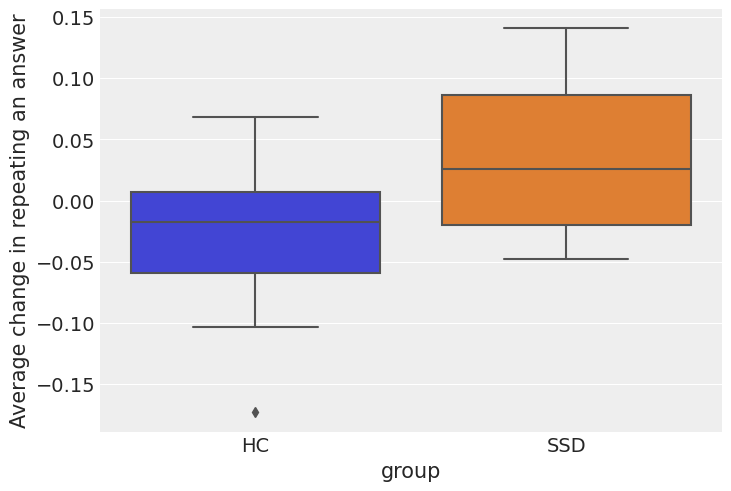

In [23]:
# as already indicated in the model parameters we see a difference in the development between HC and SSDs:

sns.boxplot(subj_data, x="group", y="saac")
a = subj_data[subj_data["group"] == "HC"]["saac"]
b = subj_data[subj_data["group"] == "SSD"]["saac"]
plt.ylabel("Average change in repeating an answer")
print(f"t-test of group difference: {ttest(a,b)}")
from scipy.stats import ttest_1samp
print(f"t-test of HCs being smaller than 0: {ttest_1samp(a, 0, alternative='less')}")
print(f"t-test of SSDs being bigger than 0: {ttest_1samp(b, 0, alternative='greater')}")

Dependant variable: saac
Independent variable: SAPS
	statistic: 0.09, p: 0.73
	CI: low: -0.39, high: 0.53
Independent variable: SAPS 2
	statistic: 0.12, p: 0.66
	CI: low: -0.37, high: 0.55
Independent variable: SANS
	statistic: -0.16, p: 0.53
	CI: low: -0.58, high: 0.32
Independent variable: SANS 5
	statistic: -0.11, p: 0.67
	CI: low: -0.55, high: 0.37



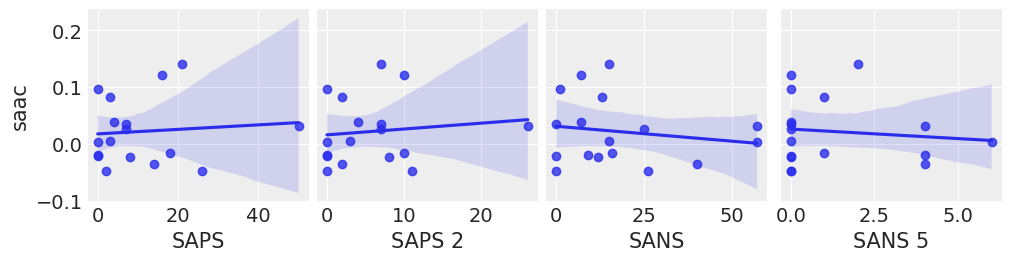

In [24]:
# calculcate correlation of this number to symptoms
ssds = subj_data[subj_data["group"] == "SSD"]
sns.pairplot(ssds, x_vars=[*saps_vars, *sans_vars], y_vars=["saac"], kind="reg")

dep_vars = ["saac"]
indep_vars = [*saps_vars, *sans_vars]
confidence_level=0.94

for dep_var in dep_vars:
    print(f"Dependant variable: {dep_var}")
    for indep_var in indep_vars:
        print(f"Independent variable: {indep_var}")
        df = ssds[[dep_var, indep_var]].dropna()
        res = stats.pearsonr(df[indep_var], df[dep_var])
        ci = res.confidence_interval(confidence_level=confidence_level) # computed using Fisher transformation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
        print(f"\tstatistic: {round(res.statistic, 2)}, p: {round(res.pvalue, 2)}")
        print(f"\tCI: low: {round(ci.low, 2)}, high: {round(ci.high, 2)}")
    print()

## 4. General tendency to report causal/ non-causal

In [28]:
from scipy.stats import mannwhitneyu

TtestResult(statistic=-3.0493946082048793, pvalue=0.0022944403621848143, df=42524.0)
MannwhitneyuResult(statistic=190.0, pvalue=0.7971974192691748)
-0.07346853457410688


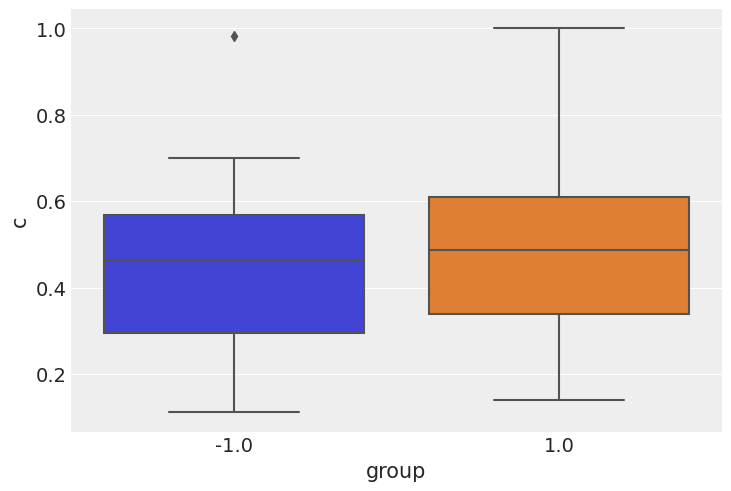

In [ ]:
dfp = data.replace({"causal": 1, "non_causal": 0, "SZ": "SSD", "HC": -1, "SZ": 1})

a = dfp[dfp["group"] == -1]["c"]
b = dfp[dfp["group"] == 1]["c"]
print(ttest(a,b))

hcs = dfp[dfp["group"] == -1]
ssds = dfp[dfp["group"] == 1]
a = hcs.groupby("subj").mean(numeric_only=True)["c"]
b = ssds.groupby("subj").mean(numeric_only=True)["c"]
print(mannwhitneyu(a,b))

print(cohens_d(a,b))

sns.boxplot(dfp.groupby("subj").mean(numeric_only=True), x="group", y="c")
plt.show()

## 5. Other choice-history measures

Does not converge

In [26]:
mydata = nested_model_data[nested_model_data["base_stim"] == 1]
trace_file = os.path.join(TRACE_PATH, "trial_properties_c_seq_interactions_pre.nc")
model_trial_properties_c_seq_interactions_pre = bmb.Model("c ~ group * delay_norm * angle_norm * c_seq * angle1_norm * delay1_norm\
                                                          + group * delay_norm * angle_norm * nc_seq * nc_seq * angle1_norm * delay1_norm\
                                                          + (1|subj)", mydata, family="bernoulli")

# sample
trace_trial_properties_c_seq_interactions_pre = loadOrSample(model_trial_properties_c_seq_interactions_pre, trace_file)
sum_trial_properties_c_seq_interactions_pre = az.summary(trace_trial_properties_c_seq_interactions_pre)

Loading trace from file.


In [27]:
sum_trial_properties_c_seq_interactions_pre

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        -2.909  0.959  -3.888   -1.744      0.478    0.366       4.0   
group            -0.176  0.270  -0.429    0.233      0.135    0.103       4.0   
delay_norm       -0.272  0.438  -0.979    0.127      0.218    0.167       4.0   
group:delay_norm -0.364  0.375  -0.945    0.089      0.187    0.143       4.0   
angle_norm       -0.224  0.678  -0.909    0.557      0.338    0.259       4.0   
...                 ...    ...     ...      ...        ...      ...       ...   
1|subj[116.0]     0.276  0.465  -0.402    0.759      0.232    0.177       4.0   
1|subj[117.0]     0.228  1.964  -1.270    3.577      0.978    0.749       5.0   
1|subj[118.0]    -0.498  0.729  -1.546    0.189      0.363    0.278       5.0   
1|subj[119.0]     1.426  1.599  -0.156    4.093      0.796    0.610       4.0   
1|subj[120.0]    -1.226  0.999  -2.731   -0.013      0.497    0.381       4.0   

                  ess_tail  r_hat  
Intercept             11.0   4.17  
group                 14.0   3.54  
delay_norm            11.0   3.62  
group:delay_norm      14.0   3.45  
angle_norm            15.0   3.30  
...                    ...    ...  
1|subj[116.0]         11.0   4.06  
1|subj[117.0]         13.0   3.23  
1|subj[118.0]         34.0   2.95  
1|subj[119.0]         14.0   3.51  
1|subj[120.0]         14.0   3.84  

[137 rows x 9 columns]